# Maximum Likelihood vs CDF-Fit (Spiral B)

In [75]:
import matplotlib.pyplot as plot
import numpy as np
import sympy as sp

from math import exp, log, sqrt
from scipy.optimize import curve_fit, fsolve

import DistA as dist

from StopWatch import StopWatch
from LocUtil import LogGrid1, Sub, UnZip
from LocMath import RandLog

#### Constants

In [76]:
aTrue = 1.7

nMin = 30
nMax = 30_000
nN = 300

givenSeed = None

nPlot = 101
figSize = (9, 6.5)

#### Generate List of N's

In [77]:
nL = tuple(round(RandLog(nMin,nMax)) for _ in range(nN))

## Estimation Code

In [78]:
termSym = sp.log(dist.pdfSym).diff(dist.aSym).simplify()
termSym

(1 - 2*x)/(a - 2*x*(a - 1))

#### Hand Coded

In [79]:
sampTest = np.array(tuple(np.float64(dist.GenSamp(aTrue)) for _ in range(10_000)))

In [80]:
def MaxEst(samp):
  def f(a, samp):
    assert(type(samp) == np.ndarray)
    terms = (1 - 2*samp) / (a + 2*(1 - a) * samp)
    result = np.sum(terms)
    return result

  result = fsolve(f,1, args=samp)
  return result[0]

In [81]:
timer = StopWatch(running=True)
est = MaxEst(sampTest)
timer.Stop()
est, f'{timer.Delta()}'

(1.7019141362819525, '0:00:00.002481')

#### MLE Estimator

In [82]:
def MleEst(samp):
  termSym = sp.log(dist.pdfSym).diff(dist.aSym).simplify()
  
  fTemp = (
    'def f(a, x):\n'
    '  terms = {}\n'
    '  result = np.sum(terms)\n'
    '  return result'
  )
  fCode = fTemp.format(termSym)
  # print(fCode)
  
  execScope = {}
  exec(fCode, globals(), execScope)
  f = execScope['f']
  
  timer = StopWatch(running=True)
  ans = fsolve(f,1, args=samp)
  timer.Stop()

  return ans[0]

In [83]:
timer = StopWatch(running=True)
est = MleEst(sampTest)
timer.Stop()
est, f'{timer.Delta()}'

(1.7019141362819525, '0:00:00.033171')

#### CDF-Fit Estimator

In [84]:
def CdfFitEst(samp):
  n = len(samp)
  quant = tuple((k + 0.5)/n for k in range(n))
  
  optParam,_ = curve_fit(dist.CdfNum, sorted(samp),quant)
  
  return optParam[0]

In [85]:
timer = StopWatch(running=True)
est = CdfFitEst(sampTest)
timer.Stop()
est, f'{timer.Delta()}'

(1.7051174703318828, '0:00:00.009795')

### Generate Data

In [86]:
mleEst = []
cdfEst = []

for n in nL:
  samp = np.array(tuple(dist.GenSamp(aTrue) for _ in range(n)))
  
  mEst = MleEst(samp)
  mleEst.append(mEst)
  
  cEst = CdfFitEst(samp)
  cdfEst.append(cEst)

In [87]:
nLog = tuple(log(n) for n in nL)

In [88]:
mleErr = list(aEst - aTrue for aEst in mleEst)
mleAbsErr = list(abs(e) for e in mleErr)
mleLogErr = [log(e) for e in mleAbsErr]

In [89]:
cdfErr = list(aEst - aTrue for aEst in cdfEst)
cdfAbsErr = list(abs(e) for e in cdfErr)
cdfLogErr = [log(e) for e in cdfAbsErr]

## Fit Allowing the Power to Vary

In [90]:
linFit = lambda n, a0,a1: a0 + a1*n

In [91]:
mleLinFit,_ = curve_fit(linFit, nLog, mleLogErr)
mleLinFit

array([-0.32924014, -0.49501384])

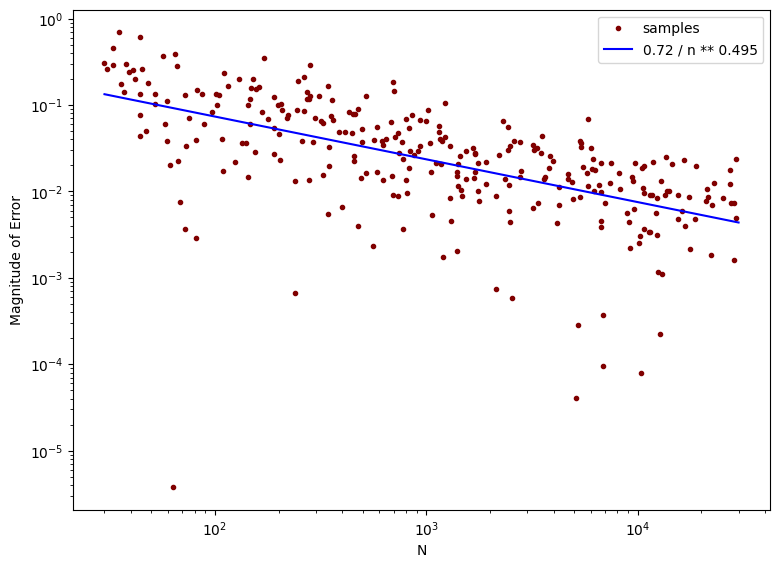

In [92]:
plot.figure(figsize=figSize)
plot.loglog(nL, mleAbsErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

a0,a1 = mleLinFit
fitGrid = [exp(a0) * n**a1 for n in nGrid]
text = f'{exp(a0):.2f} / n ** {-a1:.3f}'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Fit Constraining Power to be -1/2

#### MLE Fit

In [93]:
komFit = lambda n, k: k - n/2

In [94]:
mleKomFit,_ = curve_fit(komFit, nLog, mleLogErr)
mleKomFit

array([-0.29452768])

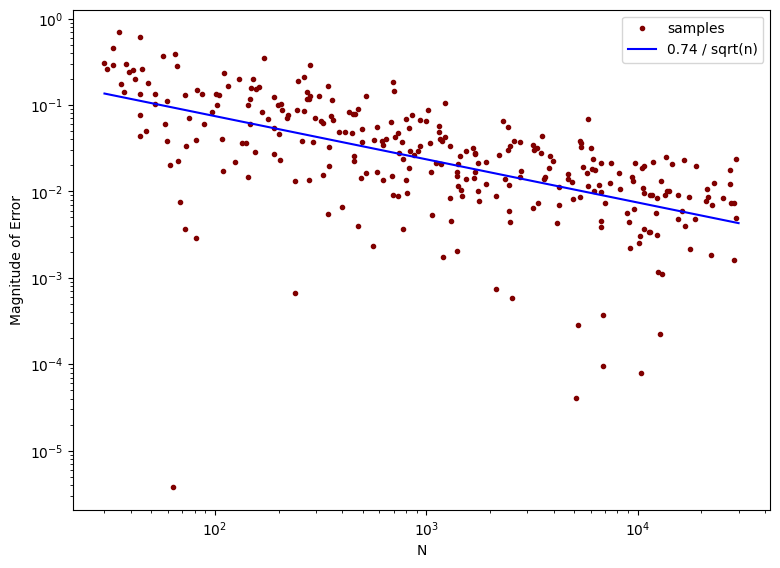

In [95]:
plot.figure(figsize=figSize)
plot.loglog(nL, mleAbsErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

k = mleKomFit[0]
fitGrid = [exp(k) / sqrt(n) for n in nGrid]
text = f'{exp(k):.2f} / sqrt(n)'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

#### CDF-Fit

In [96]:
cdfKomFit,_ = curve_fit(komFit, nLog, cdfLogErr)
cdfKomFit

array([-0.07970189])

In [97]:
exp(cdfKomFit[0])

0.9233915791761361

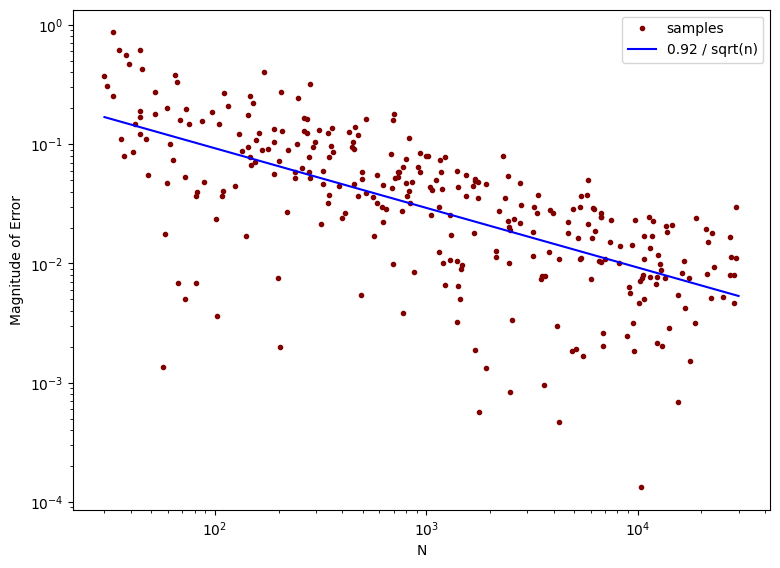

In [98]:
plot.figure(figsize=figSize)
plot.loglog(nL, cdfAbsErr, '.', color='maroon', label='samples')

nGrid = LogGrid1(nMin,nMax, nPlot)

k = cdfKomFit[0]
fitGrid = [exp(k) / sqrt(n) for n in nGrid]
text = f'{exp(k):.2f} / sqrt(n)'
plot.loglog(nGrid, fitGrid, c='blue', label=text)

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

## Pair Match

Are there any matches

In [99]:
[k for k in range(nN) if mleAbsErr[k] == cdfAbsErr[k]]

[]

In [100]:
mleWinIndex = [k for k in range(nN) if mleAbsErr[k] < cdfAbsErr[k]]
cdfWinIndex = [k for k in range(nN) if cdfAbsErr[k] < mleAbsErr[k]]

In [101]:
mleData = Sub(list(zip(nL,mleAbsErr)), mleWinIndex)
cdfData = Sub(list(zip(nL,cdfAbsErr)), cdfWinIndex)

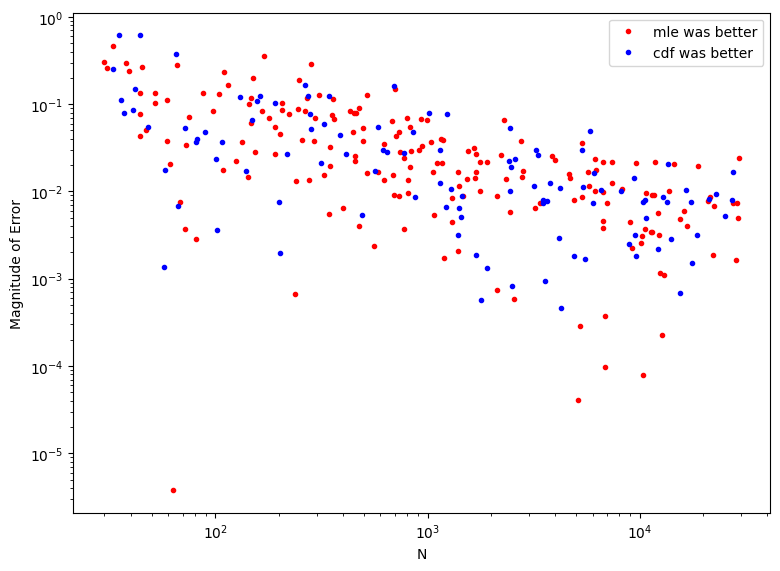

In [104]:
plot.figure(figsize=figSize)

plot.loglog(*UnZip(mleData), '.', color='red', label='mle was better')
plot.loglog(*UnZip(cdfData), '.', color='blue', label='cdf was better')

plot.xlabel('N')
plot.ylabel('Magnitude of Error')
plot.legend()

There doesn't appear to be any pattern to the instances where MLE is better the CDF-Fit.  But it 
is better most of the time.